<a href="https://www.kaggle.com/code/iqmansingh/mobilenetv2-dogs-vs-cats?scriptVersionId=135144697" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<img src="https://cdn.discordapp.com/attachments/1111599839663370271/1123589551244460072/CatsVsDogs.jpg">

# **Transfer Learning & Fine Tuning on MobileNetV2**

---

# Importing Libraries

In [50]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import datetime
import warnings
warnings.filterwarnings("ignore")
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('dark_background')
from tqdm import tqdm_notebook

In [51]:
tf.test.is_built_with_cuda()

True

In [52]:
tf.test.is_gpu_available()

True

---

# Defining Classes & Generators

In [53]:
classes = ['cats','dogs']

In [54]:
generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.0, 
                               shear_range=0.15, 
                               zoom_range=0.2, 
                               horizontal_flip=True) 

train_data = generator.flow_from_directory( directory='../input/cat-and-dog/training_set/training_set', 
                                            target_size=(128, 128),
#                                             color_mode='grayscale',
                                            classes=classes, 
                                            batch_size=128)


test_data = generator.flow_from_directory( directory='../input/cat-and-dog/test_set/test_set', 
                                           target_size=(128, 128), 
#                                            color_mode='grayscale',
                                           classes=classes, 
                                           batch_size=128,
                                           shuffle=False)

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


---

# MobileNetV2

### Loading the Model

In [55]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(128,128,3),include_top=False,weights="imagenet")

In [56]:
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_4[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][

### Freezing the Model

In [57]:
base_model.trainable = False

### Defining the Custom Head for network

In [58]:
base_model.output

<KerasTensor: shape=(None, 4, 4, 1280) dtype=float32 (created by layer 'out_relu')>

#### 2 Apporaches can be taken
1. Using Flattening Layer
2. Using GlobalAveragePooling Layer

In [59]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
global_average_layer

<KerasTensor: shape=(None, 1280) dtype=float32 (created by layer 'global_average_pooling2d_3')>

In [60]:
pred_layer = tf.keras.layers.Dense(units=2,activation="sigmoid")(global_average_layer)

In [61]:
model = tf.keras.models.Model(inputs=base_model.input, outputs=pred_layer)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_4[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']         

### Compiling the model

In [62]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.01),loss="categorical_crossentropy",metrics=["accuracy"])

### Training the model

In [63]:
earlyStopping =  tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_accuracy',restore_best_weights=True,start_from_epoch=2)

# history = model.fit_generator(train_data, epochs=5, validation_data=test_data,callbacks=[earlyStopping])
history = model.fit(train_data, epochs=10, validation_data=test_data, shuffle=True, callbacks=[earlyStopping],batch_size=64)

Epoch 1/10
63/63 [==============================] - 66s 1s/step - loss: 0.2372 - accuracy: 0.9013 - val_loss: 0.1267 - val_accuracy: 0.9506
Epoch 2/10
63/63 [==============================] - 65s 1s/step - loss: 0.1269 - accuracy: 0.9475 - val_loss: 0.1118 - val_accuracy: 0.9600
Epoch 3/10
63/63 [==============================] - 62s 986ms/step - loss: 0.1050 - accuracy: 0.9569 - val_loss: 0.1219 - val_accuracy: 0.9525
Epoch 4/10
63/63 [==============================] - 60s 947ms/step - loss: 0.1009 - accuracy: 0.9578 - val_loss: 0.1065 - val_accuracy: 0.9560
Epoch 5/10
63/63 [==============================] - 62s 985ms/step - loss: 0.0938 - accuracy: 0.9630 - val_loss: 0.1101 - val_accuracy: 0.9605
Epoch 6/10
63/63 [==============================] - 67s 1s/step - loss: 0.0938 - accuracy: 0.9628 - val_loss: 0.1007 - val_accuracy: 0.9585
Epoch 7/10
63/63 [==============================] - 61s 961ms/step - loss: 0.0916 - accuracy: 0.9643 - val_loss: 0.1180 - val_accuracy: 0.9555
Epoch 8/

In [64]:
df = pd.DataFrame(history.history)
df_loss = df[['loss', 'val_loss']]
df_acc =  df[['accuracy', 'val_accuracy']]

In [68]:
df_acc.head()

,accuracy,val_accuracy
0,0.901312,0.950568
1,0.947533,0.959960
2,0.956902,0.952546
3,0.957776,0.956006
4,0.963023,0.960455


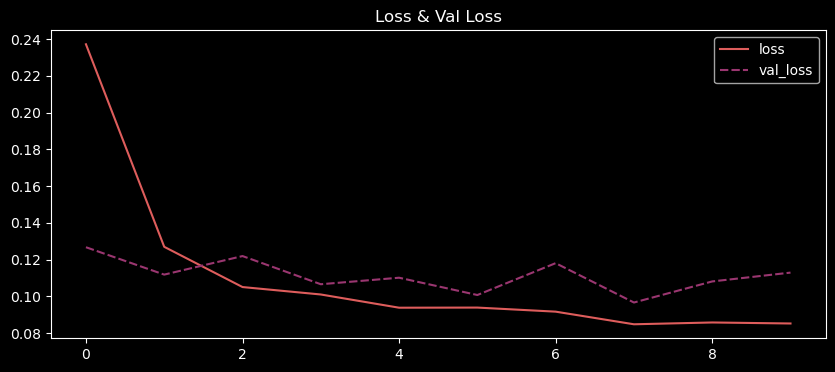

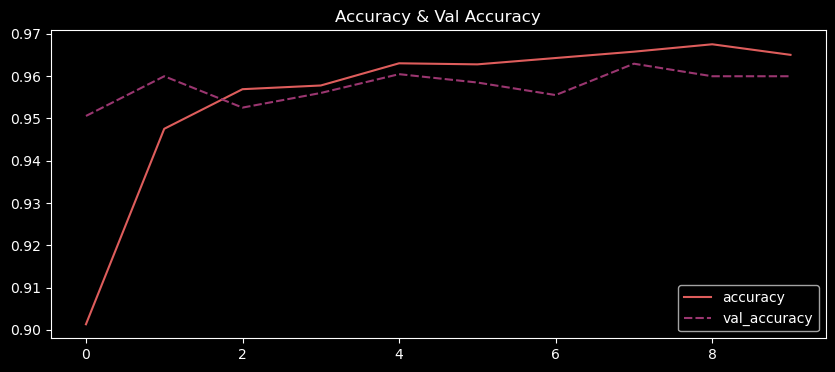

In [70]:
plt.figure(figsize=(10, 4))
plt.title("Loss & Val Loss")
sns.lineplot(df_loss,palette="flare");

plt.figure(figsize=(10, 4))
plt.title("Accuracy & Val Accuracy")
sns.lineplot(df_acc,palette="flare");

### Fine-Tuning Base Model

- DO NOT use Fine tuning on the whole network; only a few top layers are enough. In most cases, they are more specialized. The goal of the Fine-tuning is to adopt that specific part of the network for our custom (new) dataset.
- Start with the fine tunning AFTER you have finished with transfer learning step. If we try to perform Fine tuning immediately, gradients will be much different between our custom head layer and a few unfrozen layers from the base model. 

In [78]:
base_model.trainable=True

In [79]:
print("No of layers in base MobleNetV2 model",len(base_model.layers))

No of layers in base MobleNetV2 model 154


In [80]:
layersToUnfreezeFrom = 124
# Hence we will fine tune all layers from 124 to 154

for layer in base_model.layers[:layersToUnfreezeFrom]:
    layer.trainable = False

In [81]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001),loss="categorical_crossentropy",metrics=["accuracy"])

history = model.fit(train_data, epochs=10, validation_data=test_data, shuffle=True, callbacks=[earlyStopping],batch_size=64)

Epoch 1/10
63/63 [==============================] - 68s 967ms/step - loss: 0.0413 - accuracy: 0.9856 - val_loss: 1.1480 - val_accuracy: 0.9328
Epoch 2/10
63/63 [==============================] - 62s 980ms/step - loss: 0.0343 - accuracy: 0.9864 - val_loss: 0.6394 - val_accuracy: 0.9451
Epoch 3/10
63/63 [==============================] - 63s 996ms/step - loss: 0.0297 - accuracy: 0.9898 - val_loss: 0.8903 - val_accuracy: 0.9402
Epoch 4/10
63/63 [==============================] - 61s 968ms/step - loss: 0.0250 - accuracy: 0.9910 - val_loss: 0.9849 - val_accuracy: 0.9367
Epoch 5/10
63/63 [==============================] - 61s 976ms/step - loss: 0.0186 - accuracy: 0.9933 - val_loss: 1.1048 - val_accuracy: 0.9402
Epoch 6/10
63/63 [==============================] - 61s 978ms/step - loss: 0.0163 - accuracy: 0.9945 - val_loss: 1.1132 - val_accuracy: 0.9392


In [82]:
df = pd.DataFrame(history.history)
df_loss = df[['loss', 'val_loss']]
df_acc =  df[['accuracy', 'val_accuracy']]

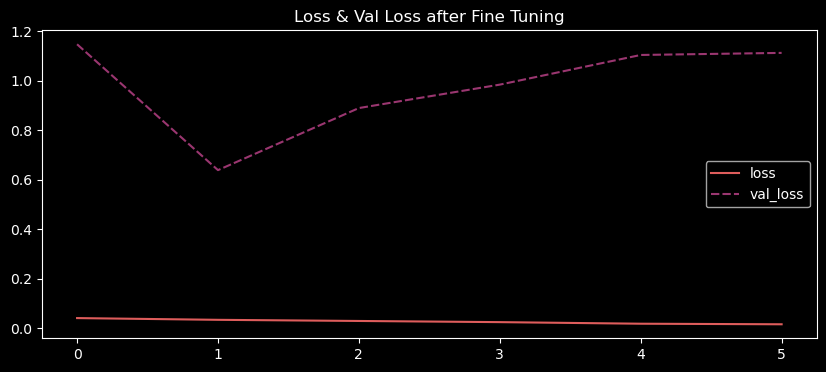

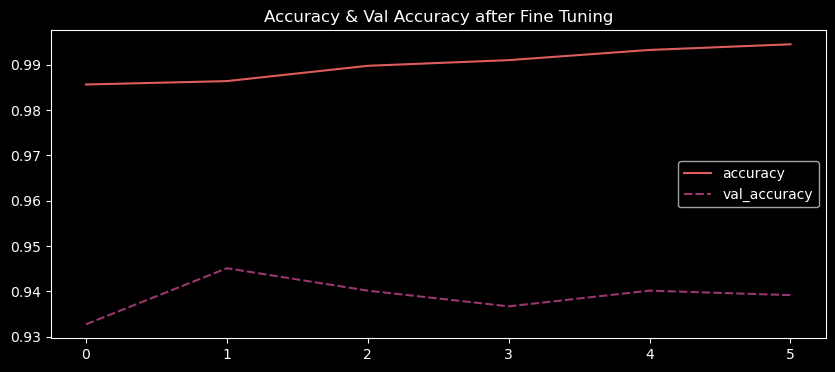

In [83]:
plt.figure(figsize=(10, 4))
plt.title("Loss & Val Loss after Fine Tuning")
sns.lineplot(df_loss,palette="flare");

plt.figure(figsize=(10, 4))
plt.title("Accuracy & Val Accuracy after Fine Tuning")
sns.lineplot(df_acc,palette="flare");